In [1]:
import os
file_path = os.path.abspath(".")
execution_path = os.path.abspath(f"../../../../Binaries/Debug")

In [2]:
import os
os.chdir(file_path)
import sys
target_path = os.path.abspath(f"../../../../Binaries/Debug")
sys.path.append(target_path)
print(f"Added {target_path} to sys.path")
package_path = os.path.abspath(f"../python")
sys.path.append(package_path)
print(f"Added {package_path} to sys.path")

Added c:\Users\pengfei\WorkSpace\USTC_CG_24\Framework3D\Binaries\Debug to sys.path
Added c:\Users\pengfei\WorkSpace\USTC_CG_24\Framework3D\source\Runtime\renderer\python to sys.path


In [3]:
import glints.scratch_grid
import glints.renderer
import glints.test_utils as test_utils
import torch
import numpy as np
import pytest


In [4]:
import importlib
importlib.reload(glints.scratch_grid)

<module 'glints.scratch_grid' from 'c:\\Users\\pengfei\\WorkSpace\\USTC_CG_24\\Framework3D\\source\\Runtime\\renderer\\python\\glints\\scratch_grid.py'>

In [12]:
def linear_to_gamma(image):
    return image ** (1.0 / 2.2)


def render_and_save_field(field, resolution, filename):
    r = glints.renderer.Renderer()
    vertices, indices = glints.renderer.plane_board_scene_vertices_and_indices()
    camera_position_np = np.array([4.0, 0.1, 2.5], dtype=np.float32)
    r.set_camera_position(camera_position_np)
    fov_in_degrees = 35
    r.set_perspective(
        np.pi * fov_in_degrees / 180.0, resolution[0] / resolution[1], 0.1, 1000.0
    )
    r.set_mesh(vertices, indices)
    r.set_light_position(torch.tensor([4.0, -0.1, 2.5], device="cuda"))

    r.set_width(torch.tensor([0.001], device="cuda"))

    image, sampled_mask = glints.scratch_grid.render_scratch_field(r, resolution, field)
    test_utils.save_image(image, resolution, filename)


import matplotlib.pyplot as plt


def sub_test_field(field, arrow_distance, filename):

    # test importance sample

    np_sub_field = field.field[:, :, 0, :].detach().cpu().numpy()

    np_sub_density_field = np.linalg.norm(np_sub_field, axis=2)
    np_sub_direction_field = np_sub_field / np_sub_density_field[:, :, None]
    init_points = []

    for i in range(100):
        init_point = field._ScratchField__importance_sample_field(
            np_sub_density_field
        )  # np.array([x, y])
        if init_point is not None:
            init_points.append(init_point)

    plt.figure(figsize=(10, 10))

    # draw the arrows
    W = field.field.shape[1]
    H = field.field.shape[0]

    plt.quiver(
        np.arange(0, W, arrow_distance),
        np.arange(0, H, arrow_distance),
        np_sub_direction_field[::arrow_distance, ::arrow_distance, 1],
        np_sub_direction_field[::arrow_distance, ::arrow_distance, 0],
    )

    # do the scatter plot of init_points
    init_points = np.array(init_points)
    plt.scatter(init_points[:, 1], init_points[:, 0], s=1)

    for i in range(100):
        grown_curve = field._ScratchField__grow_init_point(
            np_sub_direction_field, np_sub_density_field, init_points[i], 0.6
        )

        plt.plot(grown_curve[:, 1], grown_curve[:, 0], color="red")

    plt.savefig(filename)
    plt.close()


def optimize_field(
    field,
    renderer,
    resolution,
    target_image,
    loss_fn,
    regularization_loss_fn,
    regularizer,
    optimizer,
):
    old_regularization_loss = None
    for i in range(400):
        regularizer.zero_grad()
        divergence, smoothness = field.calc_divergence_smoothness()
        loss_divergence = regularization_loss_fn(
            divergence, torch.zeros_like(divergence)
        )
        loss_smoothness = regularization_loss_fn(
            smoothness, torch.zeros_like(smoothness)
        )
        resularization_loss = loss_divergence + loss_smoothness

        if i == 0:
            old_regularization_loss = resularization_loss.item()

        resularization_loss.backward()
        regularizer.step()
        field.fix_direction()

    for _ in range(200):
        optimizer.zero_grad()
        image, sampled_mask = glints.scratch_grid.render_scratch_field(
            renderer, resolution, field
        )
        loss_image = loss_fn(linear_to_gamma(image), target_image) * 1000
        density_loss = torch.mean(
            torch.norm(field.field[sampled_mask].reshape(-1, 2), dim=1) * 0.1
        )
        total_loss = loss_image + density_loss
        total_loss.backward()
        optimizer.step()
        field.fill_masked_holes(sampled_mask)

        resularization_loss = torch.tensor(10000000000000.0)
        regularization_steps = 0

        if True:
            while resularization_loss.item() > old_regularization_loss:
                regularizer.zero_grad()
                divergence, smoothness = field.calc_divergence_smoothness()
                loss_divergence = regularization_loss_fn(
                    divergence, torch.zeros_like(divergence)
                )
                loss_smoothness = regularization_loss_fn(
                    smoothness, torch.zeros_like(smoothness)
                )
                resularization_loss = loss_divergence + loss_smoothness
                resularization_loss.backward()
                regularizer.step()
                regularization_steps += 1

        print(
            "iteration:",
            _,
            "loss_divergence",
            loss_divergence.item(),
            "loss_smoothness",
            loss_smoothness.item(),
            "density_loss",
            density_loss.item(),
            "loss_image",
            loss_image.item(),
            "total_loss",
            total_loss.item(),
            "regularization_steps",
            regularization_steps,
        )

    field.fix_direction()


def save_images(field, resolution, divergence, smoothness):
    for i in range(field.field.shape[2]):
        test_utils.save_image(
            1000 * divergence[:, :, i], resolution, f"divergence_{i}.exr"
        )
        test_utils.save_image(
            100 * smoothness[:, :, i], resolution, f"smoothness_{i}.exr"
        )

        density = torch.norm(field.field[:, :, i], dim=2)
        directions = field.field[:, :, i] / density.unsqueeze(2)
        directions = torch.cat(
            [directions, torch.zeros_like(directions[:, :, :1])], dim=2
        )

        test_utils.save_image(directions, resolution, f"directions_{i}.exr")
        test_utils.save_image(density, resolution, f"density_{i}.exr")
        test_utils.save_image(field.field[:, :, i, :1], resolution, f"field_{i}.exr")

In [7]:

os.chdir(execution_path)
r = glints.renderer.Renderer()

vertices, indices = glints.renderer.plane_board_scene_vertices_and_indices()
camera_position_np = np.array([4.0, 0.0, 3.5], dtype=np.float32)
r.set_camera_position(camera_position_np)
fov_in_degrees = 35
resolution = [768 * 2, 512 * 2]
r.set_perspective(
    np.pi * fov_in_degrees / 180.0, resolution[0] / resolution[1], 0.1, 1000.0
)
r.set_mesh(vertices, indices)
r.set_light_position(torch.tensor([4.0, -0.0, 4.5], device="cuda"))

r.set_width(torch.tensor([0.001], device="cuda"))

field = glints.scratch_grid.ScratchField(512, 3)
image, sampled_mask = glints.scratch_grid.render_scratch_field(r, resolution, field)
test_utils.save_image(image, resolution, "scratch_field_initial.exr")
target_image = r.prepare_target("texture.png", resolution)
loss_fn = torch.nn.L1Loss()
regularization_loss_fn = torch.nn.L1Loss()
regularizer = torch.optim.Adam([field.field], lr=0.005)
optimizer = torch.optim.Adam([field.field], lr=0.01)

optimize_field(
    field,
    r,
    resolution,
    target_image,
    loss_fn,
    regularization_loss_fn,
    regularizer,
    optimizer,
)


c:\Users\pengfei\WorkSpace\USTC_CG_24\Framework3D\source\Runtime\renderer\python\glints\renderer.py:204: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch_texture = torch.tensor(texture, device="cuda")


iteration: 0 loss_divergence 2.1848840713500977 loss_smoothness 0.0006445965263992548 density_loss 0.04994211718440056 loss_image 91.41285705566406 total_loss 91.46279907226562 regularization_steps 1
iteration: 1 loss_divergence 3.5421152114868164 loss_smoothness 0.0007624607533216476 density_loss 0.05072544515132904 loss_image 86.7278060913086 total_loss 86.77853393554688 regularization_steps 1
iteration: 2 loss_divergence 4.938546180725098 loss_smoothness 0.0009271215531043708 density_loss 0.051503948867321014 loss_image 82.39105987548828 total_loss 82.44256591796875 regularization_steps 1
iteration: 3 loss_divergence 6.370816707611084 loss_smoothness 0.0011243270710110664 density_loss 0.0522509440779686 loss_image 78.43017578125 total_loss 78.48242950439453 regularization_steps 1
iteration: 4 loss_divergence 7.7326202392578125 loss_smoothness 0.0013439087197184563 density_loss 0.05293001979589462 loss_image 74.85089874267578 total_loss 74.9038314819336 regularization_steps 1
iterati

break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density
break because of density


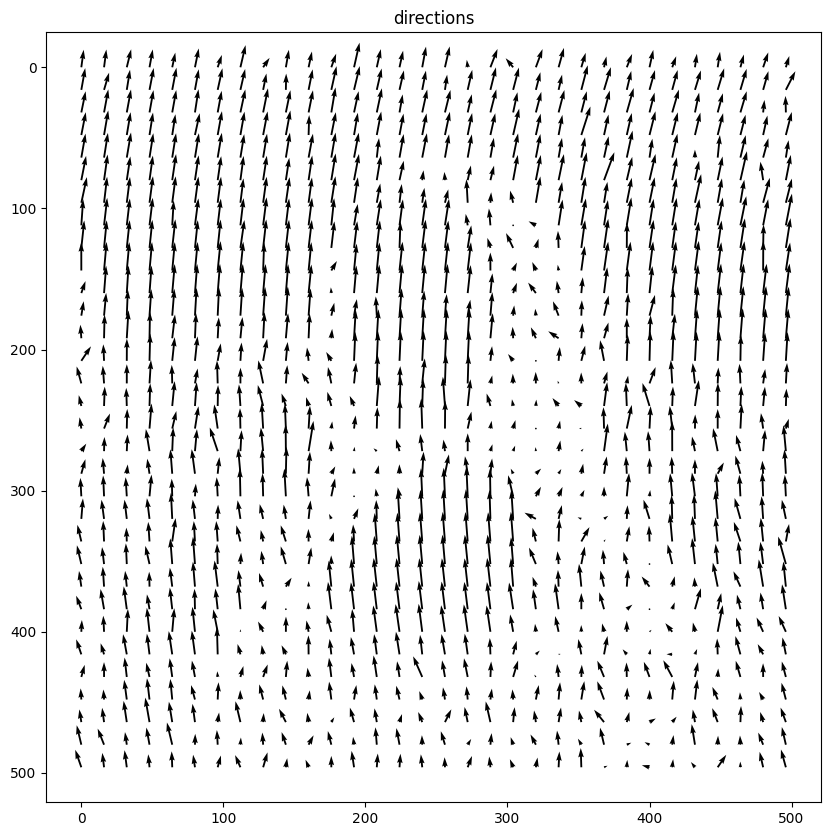

In [14]:
divergence, smoothness = field.calc_divergence_smoothness()
save_images(field, resolution, divergence, smoothness)

image, sampled_mask = glints.scratch_grid.render_scratch_field(r, resolution, field)
test_utils.save_image(image, resolution, "scratch_field.exr")

directions = torch.rot90(field.field[:, :, 0, :2])

sub_test_field(field, arrow_distance=8, filename="scratch_field.pdf")

test_utils.plot_arrows(
    directions, "directions", spacing=16, scale=0.1, filename="directions.pdf"
)